In [3]:
from data_utils import load_dataset
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Only for formatting and plotting
import math

_COLORS = ['#d6616b', '#e6550d', '#fdae6b', '#e7ba52', '#dbdb8d']

def loadData(datasetName, d=2, n=1000):
    '''
    Loads the dataset and normalize the x_ sets
    INPUT: datasetName: a string of the name of file to be loaded. Note that this file must be in the same path as this file
    OUTPUT: 6 datasets in array form, 3 of which are normalized x data
    '''
    if datasetName == 'rosenbrock':
        x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset(datasetName, n_train=n, d=d)
    else:
        x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset(datasetName)

    x_all = np.concatenate([x_train, x_valid])
    y_all = np.concatenate([y_train, y_valid])
    index_all = list(range(np.shape(x_all)[0]))
    np.random.seed(99)
    np.random.shuffle(index_all)

    # Normalizetion of each x data
    mean = x_all.mean(axis=0, keepdims=True)
    stddev = x_all.std(axis=0, keepdims=True)
    x_all = normalization(x_all, mean, stddev)
    x_test = normalization(x_test, mean, stddev)
    return index_all, x_all, x_test, y_all, y_test

def foldDataset(allIndex, x_all, y_all, foldIndex):
    '''
    Split data into two sets of ratio 4:1 according to the foldIndex
    INPUT: allData: concatenate dataset
    INPUT: foldIndex: from 1 to 5, decides how to partition the dataset (must be from outside the class)
    OUTPUT: train, set: the 4:1 ratio datasets
    '''
    total = len(allIndex)
    oneFifth = round(total/5)
    if foldIndex in [1, 2, 3, 4]:
        index_train = allIndex[:oneFifth*(foldIndex-1)] + allIndex[oneFifth*foldIndex:]
        index_valid = allIndex[oneFifth*(foldIndex-1) : oneFifth*foldIndex]
    elif foldIndex == 5: # for the last fold, cound backwards so that it has the same number of data as the other folds
        index_train = allIndex[:(total-oneFifth)]
        index_valid = allIndex[(total-oneFifth):]
    x_train, x_valid = x_all[index_train], x_all[index_valid]
    y_train, y_valid = y_all[index_train], y_all[index_valid]
    return x_train, x_valid, y_train, y_valid

def normalization(x, mean, stddev):
    '''
    Returned a matrix of x data normalized against x_train's mean and stddev
    '''
    return (x - mean)/stddev

In [4]:
class kNNTraining:
    def __init__(self, datasetName, distanceHeuristic='l2', k=3, modificationIndex=1, d=2, n=1000):
        '''
        To run kNNTraining, please declare a class with the desired parameters and then call
        "kNNtest1.kNNRegression(kNNtest1.x_test[i], kNNtest1.y_test[i])" in a loop pf desired i
        '''
        self.distanceHeuristic = distanceHeuristic # distance calculation distanceHeuristic, 'l1', 'l2', or 'linf'
        self.k = k  # number of nearest neighbours required
        self.modificationIndex = modificationIndex # chooses which method to use to modify regression, corresponding to Q3

        # Extraxt datasets associated with the dataset's name
        # x/y_train: the training sets, must be a N-by-D matrix for x_train and N-by-(#Class) for y_train
        self.index_all, self.x_all, self.x_test, self.y_all, self.y_test = loadData(datasetName, d, n)
        self.num_dimension = np.shape(self.x_test)[1]
        self.num_validSet = round(np.shape(self.x_all)[0]/5)
        self.num_trainSet = np.shape(self.x_all)[0] - self.num_validSet
        self.num_testSet = np.shape(self.x_test)[0]

    def foldDataset(self, foldIndex):
        self.x_train, self.x_valid, self.y_train, self.y_valid = foldDataset(self.index_all, self.x_all, self.y_all, foldIndex)


    def kNNClassification(self, x, y):
        '''
        Classify which class this x is in and compare to its actual value
        INOUT: x, y: 1-dimensional vectors, typically a row from x/y_test or x/y_valid
        OUTPUT: kNNClass: a classification result of class y
                correctness: a boolean indicating if the prediction is the same as label
        '''
        actualClass = y
        iNN = self.getNeighbours_2(x, y)
        # print('Selected', self.k, "nearest neighbours' classes:\n", self.y_train[iNN])

        vote, count = np.unique(self.y_train[iNN], axis=0, return_counts=True) # Find the class holding majority
        kNNClass = vote[np.argmax(count)]
        # print('Classified in class', list(kNNClass).index(True), 'and it is actually in class', list(y).index(True))

        correctness = np.unique(kNNClass == actualClass)[0] # Compare to the actual class
        # print('Classified in class', list(kNNClass).index(True), '\nResult is', correctness)
        return kNNClass, correctness


    def kNNRegression(self, x, y, modificationIndex):
        '''
        Predict the output value of given x and compare to its actual label y
        INOUT: x, y: 1-dimensional vectors, typically a row from x/y_test or x/y_valid
        INPUT: modificationIndex: one of 1, 2, 3
        OUTPUT: kNNClass: a classification result of class y
                error: absolute difference between predicted and given y's
                correctness: a boolean indicating if the prediction is within a certain boundary of its label
        '''
        actualValue = y[0]
        if modificationIndex == 1: iNN = self.getNeighbours(x, y)
        elif modificationIndex == 2: iNN = self.getNeighbours_2(x, y)
        yNN = self.y_train[iNN]
        # print('Selected', self.k, "nearest neighbours' values:\n", yNN)

        kNNValue = (sum(yNN)/len(yNN))[0]
        # print('Classified in class', list(kNNClass).index(True), 'and it is actually in class', list(y).index(True))

        error = kNNValue - actualValue # Compare to the actual class
        percent_error =  abs(error/actualValue) # Compare to the actual class
        correctness = (percent_error < 0.25)
        # print('Predicted value is', kNNValue, '\nError is', error*100, '%', 'and considered', correctness)
        return kNNValue, error, correctness

    
    def kNNRegression_4(self, x_set, y_set):
        '''
        Predict the output values of ALL x's and compare to their actual label y's -- kd tree
        INOUT: x_set, y_set: either x_test and y_test or x_valind and y_valid
        OUTPUT: kNNValues: results of class y (dimension = num_testSet or num_validSet)
                errorList: array of error
        '''
        tree = KDTree(self.x_train, leaf_size=2)              
        distances, iNN = tree.query(x_set, self.k)
        
        y_train = np.broadcast_to(self.y_train,(len(x_set),)+self.y_train.shape)
        yNN = y_train[0, iNN]
        kNNValues = np.mean(yNN, axis=1)

        errorList = kNNValues - y_set # Compare to the actual value
        return kNNValues, errorList # Both should be arrays
        errorList = kNNValues - y_set # Compare to the actual value
        return kNNValues, errorList # Both should be arrays

    
    def kNNRegression_3(self, x_set, y_set):
        '''
        Predict the output values of ALL x's and compare to their actual label y's -- fully vectorized
        INOUT: x_set, y_set: either x_test and y_test or x_valind and y_valid
        OUTPUT: kNNValues: results of class y (dimension = num_testSet or num_validSet)
                errorList: array of error
        '''
        x_train = np.broadcast_to(self.x_train,(len(x_set),)+self.x_train.shape)
        y_train = np.broadcast_to(self.y_train,(len(x_set),)+self.y_train.shape)
        x_set = np.expand_dims(x_set, axis=1)

        if self.distanceHeuristic == 'l2': distances = np.sqrt(np.sum(np.square(x_train - x_set), axis=2))
        elif self.distanceHeuristic == 'linf': distances = np.max(np.absolute(x_train - x_set), axis = 2)
        elif self.distanceHeuristic == 'l1': distances = np.sum(np.absolute(x_train - x_set), axis = 2)
            
        iNN = np.argpartition(distances, range(self.k), axis = 1)[:, :self.k]
        yNN = y_train[0, iNN]
        kNNValues = np.mean(yNN, axis=1)

        errorList = kNNValues - y_set # Compare to the actual value
        return kNNValues, errorList # Both should be arrays


    def getNeighbours_2(self, x, y):
        '''
        Get k nearest neighbours for a given x using vectorized python code instead of the for-loop over training points
        INOUT: x, y: 1-dimensional vectors, typically a row from x/y_test or x/y_valid
        OUTPUT: a list of indexes of data in x_train that are the k nearest neighbours of x
        '''
        if self.distanceHeuristic == 'l2': distances = np.sqrt(np.sum(np.square(self.x_train - x), axis=1))
        elif self.distanceHeuristic == 'linf': distances = np.max(np.absolute(self.x_train - x), axis =1)
        elif self.distanceHeuristic == 'l1': distances = np.sum(np.absolute(self.x_train - x), axis =1)
        iNN = np.argpartition(distances, range(self.k))[:self.k]
        return iNN


    def getNeighbours(self, x, y):
        '''
        Get k nearest neighbours for a given x
        INOUT: x, y: 1-dimensional vectors, typically a row from x/y_test or x/y_valid
        OUTPUT: a list of indexes of data in x_train that are the k nearest neighbours of x
        '''
        distances = [self.getDistance(self.x_train[i], self.y_train[i], x, y) for i in range(self.num_trainSet)]
        iNN = np.argpartition(distances, range(self.k))[:self.k]
        return iNN


    def getDistance(self, x1, y1, x2, y2):
        '''
        Calculates the distance with specified distanceHeuristic (default is 'l2')
        INPUT: xy1 and xy2: 1-dimensional vectors (two rows in a dataset)
        INPUT: distanceHeuristic: 'l1', 'l2', 'linf'
        OUTPUT: a numeric value of the distance
        '''
        try:
            # print('Label of x1:', y1, '\nLabel of x2:', y2)
            sum_distance = 0 # Initiate the distance
            if self.distanceHeuristic == 'l1': return np.linalg.norm(x1 - x2, 1)
            elif self.distanceHeuristic == 'l2': return np.linalg.norm(x1 - x2)
            elif self.distanceHeuristic == 'linf': return np.linalg.norm(x1 - x2, 'inf')
            else: print("Error! Input 'distanceHeuristic' must be one of 'l1', 'l2', and 'linf'.")
        except:
            print("Error! xy1 and xy2 must be 1-dimensional vectors.")
            print("x1 is now a", type(x1), 'in shape', np.shape(x1))

In [5]:
def RMSEComparison(datasetName, model, set, kRange, modificationIndex=3):
    '''
    Record the performance (RMSE) on each k value and distance metric
    INPUT: model: one of 'classification' or 'regression'
    INPUT: set: must be one of 'validation' or 'test'
    INPUT: kRange: a range of k to be tested on
    '''
    print('::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::')
    dict = {} # with keys: k and distance distanceHeuristic
    optimal = {} # with key: distance distanceHeuristic
    for distanceHeuristic in ['l1', 'l2', 'linf']:
        dict[distanceHeuristic] = {}
        for k in kRange:
            if model == 'regression': dict[distanceHeuristic][k] = RMSELoss_Regression(datasetName, set, distanceHeuristic, k, modificationIndex)
            else: dict[distanceHeuristic][k] = Accuracy_Classification(datasetName, set, distanceHeuristic, k)
        if model == 'regression': rmseOptimal = min(dict[distanceHeuristic].values())
        else: rmseOptimal = max(dict[distanceHeuristic].values())
        kOptimal = [k for k, rmse in dict[distanceHeuristic].items() if rmse == rmseOptimal]
        optimal[distanceHeuristic] = kOptimal
    df = pd.DataFrame(dict)
    print('For dataset '+datasetName+', the test results are:\n', df, '\nThe optimal k for each distance heuristic is:\n', optimal)
    print('::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::')
    return df


def RMSELoss_Regression(datasetName, set, distanceHeuristic, k, modificationIndex=3):
    '''
    Takes a dataset and calculates the root-mean-square-error(RMSE) loss of the regression with specified distance metric amd k value
    INPUT: databaseName: must be one of the regression datasets, can't be classification
    INPUT: distanceHeuristic: distance calculation distanceHeuristic, 'l1', 'l2', or 'linf'
    INPUT: k: number of nearest neighbours required
    OUTPUT: a value of the average RMSE loss across 5 folds
    '''
    # print('::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::')
    # print('Processing', datasetName, 'with', k, 'nearest neighbours using', distanceHeuristic, 'distance...')
    kNNtest = kNNTraining(datasetName, distanceHeuristic, k, modificationIndex)
    rmseValues = [] # 5 rmse values from each fold
    if set == 'validation':
        for foldIndex in range(1,6):
            kNNtest.foldDataset(foldIndex)
            errorList = []
            if modificationIndex in [1, 2]:
                for i in range(kNNtest.num_validSet):
                    kNNValue, error, correctness = kNNtest.kNNRegression(kNNtest.x_valid[i], kNNtest.y_valid[i], kNNtest.modificationIndex)
                    errorList.append(error)
                    # print(kNNtest.y_valid[i], kNNValue)
            elif modificationIndex == 3:
                kNNValue, errorList = kNNtest.kNNRegression_3(kNNtest.x_valid, kNNtest.y_valid)
            elif modificationIndex == 4:
                kNNValue, errorList = kNNtest.kNNRegression_4(kNNtest.x_valid, kNNtest.y_valid)
            rmse = np.sqrt(pow(np.array(errorList), 2).mean())
            # print('RMSE is', rmse, 'for fold', foldIndex)
            rmseValues.append(rmse)
    else:
        kNNtest.foldDataset(1)
        kNNtest.x_train, kNNtest.y_train = kNNtest.x_all, kNNtest.y_all
        errorList = []
        if modificationIndex in [1, 2]:
            for i in range(kNNtest.num_testSet):
                kNNValue, error, correctness = kNNtest.kNNRegression(kNNtest.x_test[i], kNNtest.y_test[i], kNNtest.modificationIndex)
                errorList.append(error)
        elif modificationIndex == 3:
            kNNValues, errorList = kNNtest.kNNRegression_3(kNNtest.x_test, kNNtest.y_test)
        elif modificationIndex == 4:
            kNNValue, errorList = kNNtest.kNNRegression_4(kNNtest.x_test, kNNtest.y_test)
        rmseValues.append(np.sqrt(pow(np.array(errorList), 2).mean()))
    # print('::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::')
    return np.mean(rmseValues)


def Accuracy_Classification(datasetName, set, distanceHeuristic, k):
    '''
    Takes a dataset and calculates the root-mean-square-error(RMSE) loss of the regression with specified distance metric amd k value
    INPUT: databaseName: must be one of the regression datasets, can't be classification
    INPUT: 'set': must be one of 'validation' or 'test'
    INPUT: distanceHeuristic: distance calculation distanceHeuristic, 'l1', 'l2', or 'linf'
    INPUT: k: number of nearest neighbours required
    OUTPUT: a value of the RMSE loss
    '''
    np.random.seed(20192019)
    # print('::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::')
    # print('Processing', datasetName, 'with', k, 'nearest neighbours using', distanceHeuristic, 'distance...')
    kNNtest = kNNTraining(datasetName, distanceHeuristic, k)
    Accuracies = [] # 5 rmse values from each fold
    if set == 'validation':
        for foldIndex in range(1,6):
            kNNtest.foldDataset(foldIndex)
            accuracies = []
            for i in range(kNNtest.num_validSet):
                kNNValue, correctness = kNNtest.kNNClassification(kNNtest.x_valid[i], kNNtest.y_valid[i])
                accuracies.append(correctness)
            avg = np.array(accuracies).mean()
            Accuracies.append(avg)
    else:
        kNNtest.foldDataset(1)
        kNNtest.x_train, kNNtest.y_train = kNNtest.x_all, kNNtest.y_all
        accuracies = []
        for i in range(kNNtest.num_testSet):
            kNNValue, correctness = kNNtest.kNNClassification(kNNtest.x_test[i], kNNtest.y_test[i])
            accuracies.append(correctness)
        Accuracies.append(np.array(accuracies).mean())
    # print('::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::')
    return np.mean(Accuracies)

In [16]:
Q1_Regression = {}
print('Processing dataset mauna_loa...')
Q1_Regression['mauna_loa'] = RMSEComparison('mauna_loa', 'regression', 'validation', range(1, 31), 4)

Processing dataset mauna_loa...
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
For dataset mauna_loa, the test results are:
           l1        l2      linf
1   0.048766  0.048766  0.048766
2   0.034748  0.034748  0.034748
3   0.042465  0.042465  0.042465
4   0.047779  0.047779  0.047779
5   0.056833  0.056833  0.056833
6   0.064124  0.064124  0.064124
7   0.072076  0.072076  0.072076
8   0.078499  0.078499  0.078499
9   0.084152  0.084152  0.084152
10  0.088429  0.088429  0.088429
11  0.091492  0.091492  0.091492
12  0.093084  0.093084  0.093084
13  0.093264  0.093264  0.093264
14  0.092027  0.092027  0.092027
15  0.090025  0.090025  0.090025
16  0.086828  0.086828  0.086828
17  0.083502  0.083502  0.083502
18  0.080067  0.080067  0.080067
19  0.076951  0.076951  0.076951
20  0.074499  0.074499  0.074499
21  0.072748  0.072748  0.072748
22  0.072042  0.072042  0.072042
23  0.071830  0.071830  0.071830
24  0.072513  0.072513  0.072513
25  0.073488  0.073488  0.073488

In [27]:
print('Processing dataset pumadyn32nm...')
Q1_Regression['pumadyn32nm'] = RMSEComparison('pumadyn32nm', 'regression', 'validation',range(11, 41))

Processing dataset pumadyn32nm...
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
For dataset pumadyn32nm, the test results are:
           l1        l2      linf
11  0.883386  0.901126  0.983084
12  0.882108  0.899225  0.980124
13  0.879611  0.899332  0.979474
14  0.878278  0.898026  0.978867
15  0.876904  0.896746  0.977092
16  0.875445  0.896835  0.975236
17  0.875945  0.896979  0.974749
18  0.874893  0.895930  0.973623
19  0.874223  0.895664  0.973290
20  0.874857  0.895344  0.972799
21  0.874745  0.895177  0.971743
22  0.873958  0.894352  0.971673
23  0.873104  0.893947  0.971126
24  0.873535  0.894846  0.970855
25  0.872985  0.894633  0.970556
26  0.872973  0.894929  0.970842
27  0.873117  0.895326  0.970808
28  0.873294  0.895341  0.970788
29  0.874463  0.895456  0.970688
30  0.874884  0.896378  0.970625
31  0.875496  0.896785  0.970095
32  0.875848  0.896747  0.969583
33  0.875969  0.897263  0.969211
34  0.875786  0.897464  0.968942
35  0.875514  0.897795  0.96

In [36]:
print('Processing dataset rosenbrock...')
Q1_Regression['rosenbrock'] = RMSEComparison('rosenbrock', 'regression', 'validation', range(1, 31))

Processing dataset rosenbrock...
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
For dataset rosenbrock, the test results are:
           l1        l2      linf
1   0.332775  0.302071  0.284103
2   0.324385  0.313196  0.306085
3   0.326387  0.314938  0.316781
4   0.340917  0.340087  0.324859
5   0.358044  0.341096  0.346290
6   0.364532  0.350955  0.359211
7   0.384731  0.363403  0.371243
8   0.387628  0.374365  0.381987
9   0.388331  0.382530  0.399302
10  0.395729  0.393533  0.405465
11  0.411511  0.404733  0.415856
12  0.422927  0.417982  0.422297
13  0.431890  0.431304  0.430378
14  0.440227  0.437629  0.445694
15  0.446847  0.448048  0.453156
16  0.455490  0.456542  0.464046
17  0.463999  0.467643  0.474001
18  0.471164  0.468807  0.481155
19  0.478940  0.477989  0.488723
20  0.486524  0.486030  0.494573
21  0.492681  0.494561  0.502887
22  0.503494  0.502339  0.507402
23  0.507977  0.506800  0.513355
24  0.516067  0.514839  0.520491
25  0.521659  0.516910  0.5243

In [5]:
Q1_Test = {}
Q1_Test['mauna_loa'] = RMSEComparison('mauna_loa', 'regression', 'test', range(2, 3))
Q1_Test['rosenbrock'] = RMSEComparison('rosenbrock', 'regression', 'test', range(1, 2))
Q1_Test['pumadyn32nm'] = RMSEComparison('pumadyn32nm', 'regression', 'test', range(26, 27))

::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
For dataset mauna_loa, the test results are:
          l1        l2      linf
2  0.440705  0.440705  0.440705 
The optimal k for each distance heuristic is:
 {'l1': [2], 'l2': [2], 'linf': [2]}
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
For dataset rosenbrock, the test results are:
          l1        l2      linf
1  0.243397  0.237871  0.244978 
The optimal k for each distance heuristic is:
 {'l1': [1], 'l2': [1], 'linf': [1]}
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
For dataset pumadyn32nm, the test results are:
           l1        l2      linf
26  0.831297  0.854552  0.933945 
The optimal k for each distance heuristic is:
 {'l1': [26], 'l2': [26], 'linf': [26]}
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::


In [32]:
Q2_Classification = {}
print('Processing dataset iris...')
Q2_Classification['iris'] = RMSEComparison('iris', 'classification', 'validation', range(1, 31))

Processing dataset iris...
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
For dataset iris, the test results are:
           l1        l2      linf
1   0.925926  0.925926  0.925926
2   0.940741  0.918519  0.911111
3   0.940741  0.948148  0.925926
4   0.948148  0.940741  0.911111
5   0.948148  0.955556  0.918519
6   0.940741  0.955556  0.911111
7   0.940741  0.962963  0.933333
8   0.940741  0.948148  0.940741
9   0.940741  0.962963  0.955556
10  0.948148  0.962963  0.948148
11  0.948148  0.962963  0.940741
12  0.955556  0.962963  0.940741
13  0.948148  0.962963  0.933333
14  0.955556  0.955556  0.933333
15  0.948148  0.962963  0.933333
16  0.948148  0.933333  0.918519
17  0.948148  0.925926  0.903704
18  0.940741  0.918519  0.903704
19  0.948148  0.940741  0.896296
20  0.940741  0.933333  0.881481
21  0.933333  0.933333  0.881481
22  0.933333  0.940741  0.888889
23  0.925926  0.940741  0.881481
24  0.925926  0.940741  0.888889
25  0.925926  0.918519  0.881481
26  0.925

In [27]:
import os
tic = os.times()[0]
print('Processing dataset mnist_small...')
Q2_Classification['mnist_small'] = RMSEComparison('mnist_small', 'classification', 'validation', range(1, 6))
print('Process time: '+str(os.times()[0] - tic)+' sec')

Processing dataset mnist_small...
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
For dataset mnist_small, the test results are:
          l1        l2      linf
1  0.925000  0.908727  0.678545
2  0.918273  0.895364  0.648909
3  0.929091  0.911636  0.670182
4  0.925636  0.908636  0.671727
5  0.927818  0.911636  0.669727 
The optimal k for each distance heuristic is:
 {'l1': [3], 'l2': [3], 'linf': [1]}
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Process time: 7530.089999999999 sec


In [30]:
Q2_Classification['mnist_small'] = RMSEComparison('mnist_small', 'classification', 'validation', range(6, 11))

::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
For dataset mnist_small, the test results are:
           l1        l2      linf
6   0.925545  0.908273  0.665364
7   0.925909  0.910273  0.664000
8   0.924182  0.906909  0.659364
9   0.923273  0.906364  0.660182
10  0.919455  0.904273  0.657455 
The optimal k for each distance heuristic is:
 {'l1': [7], 'l2': [7], 'linf': [6]}
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::


In [39]:
Q2_Classification['mnist_small'] = RMSEComparison('mnist_small', 'classification', 'validation', range(11, 16))

::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
For dataset mnist_small, the test results are:
           l1        l2      linf
11  0.918273  0.904000  0.658364
12  0.916000  0.901818  0.653273
13  0.916818  0.902455  0.651364
14  0.913091  0.901273  0.649364
15  0.913455  0.899636  0.649273 
The optimal k for each distance heuristic is:
 {'l1': [11], 'l2': [11], 'linf': [11]}
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::


In [6]:
Q2_Test = {}
Q2_Test['mauna_loa'] = RMSEComparison('iris', 'classification', 'test', range(12, 13))
Q2_Test['rosenbrock'] = RMSEComparison('mnist_small', 'classification', 'test', range(3, 4))

::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
For dataset iris, the test results are:
      l1   l2  linf
12  1.0  1.0   1.0 
The optimal k for each distance heuristic is:
 {'l1': [12], 'l2': [12], 'linf': [12]}
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
For dataset mnist_small, the test results are:
       l1     l2   linf
3  0.937  0.928  0.679 
The optimal k for each distance heuristic is:
 {'l1': [3], 'l2': [3], 'linf': [3]}
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::


In [63]:
def plotPredictionCurves(datasetName, set, kRange, distanceHeuristic='l2', modificationIndex=3):
    '''
    Plot the prediction curve of RMSE(%) vs. k
    '''
    data = {'k':[], 'RMSE':[]}
    for k in kRange:
        data['k'].append(k)
        data['RMSE'].append(RMSELoss_Regression(datasetName, set, distanceHeuristic, k, modificationIndex))       
    rmseOptimal = min(data['RMSE'])
    kOptimalIndex = list(data['RMSE']).index(rmseOptimal)
    kOptimal = data['k'][kOptimalIndex]
    curve = pd.DataFrame(data)
    curve.plot(x='k', y='RMSE', color=_COLORS)
    plt.style.use('bmh')
    plt.xlabel('number of nearest neighbours k')
    plt.ylabel('RMSE')
    plt.title('RMSE vs. k on Dataset "%s" with %s Distance -- %s Set\nOptimal k is %d with RMSE %1.2f' %(datasetName, distanceHeuristic, set, kOptimal, rmseOptimal), loc='center', size=12)
    # plt.savefig('kNNRegression-ValidCurve-mauna_loa.png')
    plt.show()
    return kOptimal


def plotPrediction(datasetName, set, kList, distanceHeuristic='l2', modificationIndex=2):
    '''
    Plot the test set's predicted y-values vs. labelled y-values
    '''
    for k in kList:
        print(k, 'nearest neighbours using', distanceHeuristic, 'distance:')
        kNNtest = kNNTraining(datasetName, distanceHeuristic, k, modificationIndex)
        X_SET, Y_SET, Y, RMSE = [], [], [], 0
        if set == 'validation': foldRange = range(1, 6)
        else: foldRange = range(2, 3)
        for foldIndex in foldRange:
            kNNtest.foldDataset(foldIndex)
            if set == 'validation': 
                x_set, y_set = kNNtest.x_valid, kNNtest.y_valid
            else: 
                kNNtest.x_train, kNNtest.y_train = kNNtest.x_all, kNNtest.y_all
                x_set, y_set = kNNtest.x_test, kNNtest.y_test
            y, errorList, rmse =[], [], 0
            if modificationIndex in [1, 2]:
                for i in range(x_set.shape[0]):
                    kNNValue, error, correctness = kNNtest.kNNRegression(x_set[i], y_set[i], modificationIndex)
                    y.append(kNNValue)
                    errorList.append(error)
            elif modificationIndex == 3:
                y, errorList = kNNtest.kNNRegression_3(kNNtest.x_valid, kNNtest.y_valid)
            rmse = np.sqrt(pow(np.array(errorList), 2).mean())
            X_SET.append(list(x_set))
            Y_SET.append(list(y_set))
            Y.append(y)
            RMSE += rmse/len(foldRange)
        

        data = {'x': np.array(X_SET).flatten(), 'y_Labelled': np.array(Y_SET).flatten(), 'y_Predicted': np.array(Y).flatten()}
        df = pd.DataFrame(data)
        df.plot(kind='scatter',x='x',y='y_Labelled', ax=plt.gca(), marker='.', s=9, color=_COLORS[(k+5)%len(_COLORS)])
        df.plot(kind='scatter',x='x',y='y_Predicted', ax=plt.gca(), marker='*', s=7, color=_COLORS[(k*5)%len(_COLORS)])
        plt.style.use('bmh')
        plt.legend(('y_Labelled', 'y_Predicted'))
        plt.title('Predictions of Dataset "%s"\nwith %s Distance and Optimal k = %d -- %s Set' %(datasetName, distanceHeuristic, k, set), loc='center', size=12)
        # plt.savefig('kNNRegression-ValidSet-mauna_loa.png')
    plt.show()
    return RMSE

2 nearest neighbours using l2 distance:


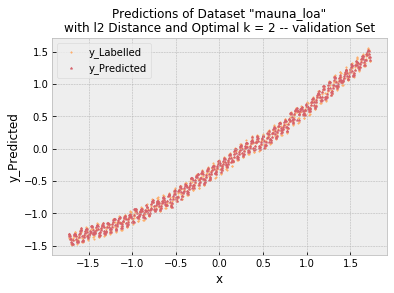

2 nearest neighbours using l2 distance:
8 nearest neighbours using l2 distance:


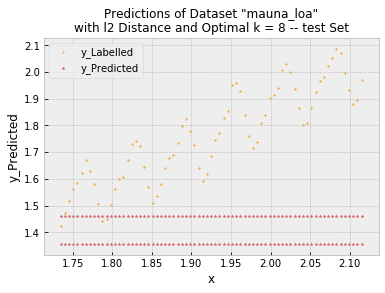

0.3461038406109373

In [64]:
plotPrediction('mauna_loa', 'validation', [2])
plotPrediction('mauna_loa', 'test', [2, 8])

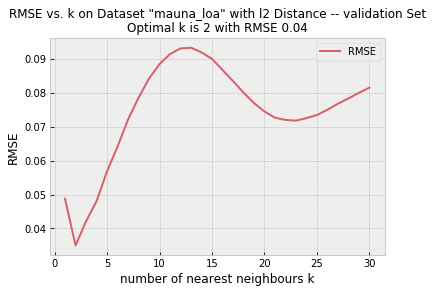

Optimal k: 2


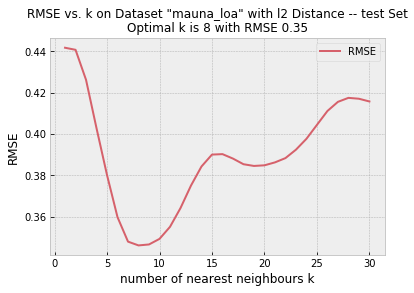

Optimal k: 8


In [41]:
print('Optimal k:', plotPredictionCurves('mauna_loa', 'validation', range(1, 31)))
print('Optimal k:', plotPredictionCurves('mauna_loa', 'test', range(1, 31)))

In [6]:
import os

def kNNPerformance(datasetName, modificationRange, distanceHeuristic='l2', k=5, dRange=[2, 10, 20, 50, 100], n=5000):
    '''
    Implements kNN in 4 different data structures/computation methods, and compare them on a graph
    INPUT: databaseName: must be one of the regression datasets, can't be classification
    INPUT: modificationRange: a range of modification indices corresponding to a, b, c and/or d in Q3 of the assignment
    INPUT: distanceHeuristic: distance calculation distanceHeuristic, here we use 'l2'
    INPUT: k: number of nearest neighbours required, here we use 5
    OUTPUT: a value of the average RMSE loss across 5 folds
    '''
    plt.figure(figsize=(15,15))
    plt.style.use('bmh') # plt.style.use('ggplot')

    for d in dRange:
        print('Processing d =', d, '...')
        kNNtest = kNNTraining(datasetName, distanceHeuristic, k, 1, d, n=5000)
        runtimes = []
        for modificationIndex in modificationRange:
            # print('::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::')
            # print('5 nearest neighbours using l2 distance with method', modificationIndex)
            kNNtest.modificationIndex = modificationIndex
            tic = os.times()[0] # Record starting time
            kNNtest.x_train, kNNtest.y_train = kNNtest.x_all, kNNtest.y_all
            y, errorList, rmse =[], [], 0
            if modificationIndex in [1, 2]:
                for i in range(kNNtest.num_testSet):
                    kNNValue, error, correctness = kNNtest.kNNRegression(kNNtest.x_test[i], kNNtest.y_test[i], kNNtest.modificationIndex)
                    y.append(kNNValue)
                    errorList.append(error)
            elif modificationIndex == 3:
                kNNValue, errorList = kNNtest.kNNRegression_3(kNNtest.x_test, kNNtest.y_test)
            elif modificationIndex == 4:
                kNNValue, errorList = kNNtest.kNNRegression_4(kNNtest.x_test, kNNtest.y_test)
            runtimes.append(os.times()[0] - tic)
            # print('::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::')
        xAxis = np.arange(len(modificationRange))
        plt.bar(xAxis, height= runtimes, alpha=0.2, color=_COLORS)
        for x in xAxis:
            plt.text(x=x-0.2, y=runtimes[x]+0.001, s='d=%d: %1.2fs'%(d, runtimes[x]), size = 11)
    plt.xticks(xAxis, ['Double For-loops', 'Single For-loop', 'Full Vectorization', 'K-d Tree'], size = 17)
    plt.xlabel('Modification Method', size = 20)
    plt.ylabel('Runtime [sec]', size = 20)
    plt.title('Runtime Comparison between Different Distance Calculation Codes \non Dataset "%s" with %s Distance k = %d' %(datasetName, distanceHeuristic, k), loc='center', size = 25)
    plt.savefig('kNNPerformance-TestSet-rosenbrock.png')
    plt.show()
    return runtimes

Processing d = 2 ...
Processing d = 10 ...
Processing d = 20 ...
Processing d = 50 ...
Processing d = 100 ...


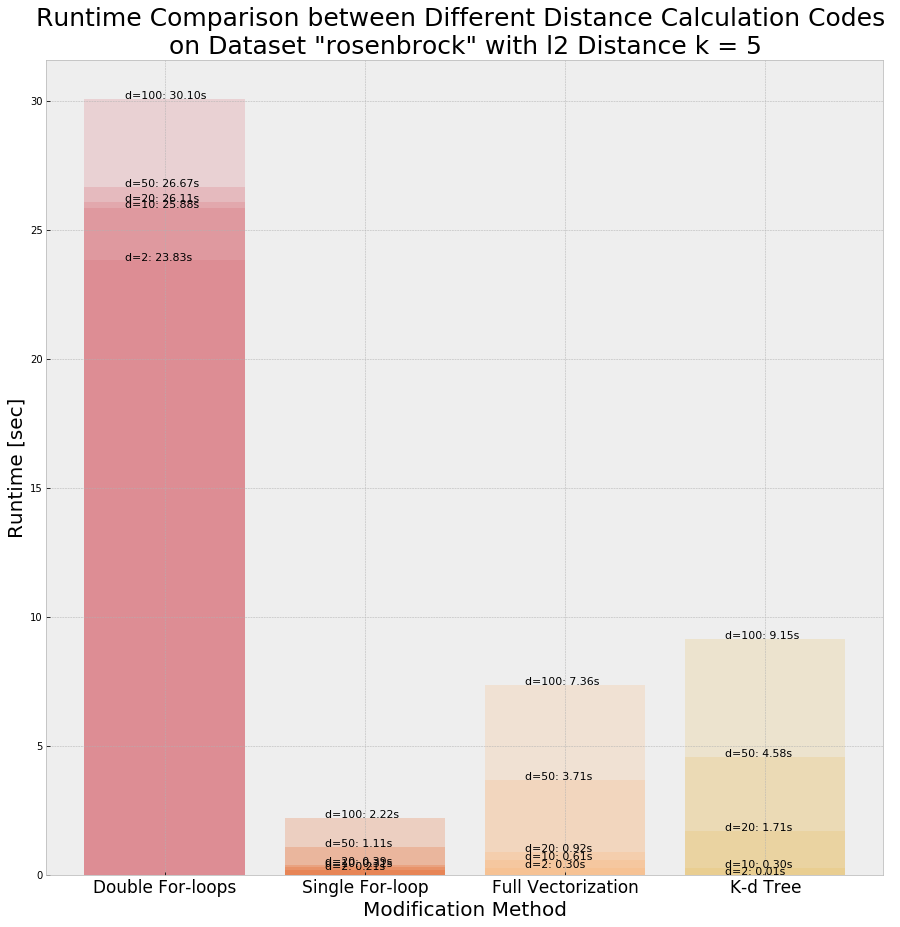

[30.10000000000001, 2.219999999999999, 7.359999999999985, 9.150000000000006]

In [8]:
kNNPerformance('rosenbrock', modificationRange=range(1,5)) #range(2,3), distanceHeuristic='l2', k=5, dRange=[2]) 

In [66]:
from numpy import dot
from matplotlib import pyplot

class LinearRegression:
    def __init__(self, datasetName, d=2):
        '''
        Takes in a dataset and calculates the weight w according to the training set
        '''
        if datasetName == 'rosenbrock':
            self.x_train, self.x_valid, self.x_test, self.y_train, self.y_valid, self.y_test = load_dataset(datasetName, n_train=1000, d=d)
        else:
            self.x_train, self.x_valid, self.x_test, self.y_train, self.y_valid, self.y_test  = load_dataset(datasetName)

        self.dataset = datasetName

        # Normalizetion of each x data
        mean = self.x_train.mean(axis=0, keepdims=True)
        stddev = self.x_train.std(axis=0, keepdims=True)
        self.x_train = (self.x_train - mean)/stddev
        self.x_valid = (self.x_valid - mean)/stddev
        self.x_test = (self.x_test - mean)/stddev
        self.num_dimension = np.shape(self.x_test)[1]
        self.num_classes = np.shape(self.y_test)[1]

        # Add x0 = 1 to each x vector
        x0 = np.ones((np.shape(self.x_train)[0], 1))
        self.x_train = np.concatenate((x0, self.x_train), axis=1)
        x0 = np.ones((np.shape(self.x_valid)[0], 1))
        self.x_valid = np.concatenate((x0, self.x_valid), axis=1)
        x0 = np.ones((np.shape(self.x_test)[0], 1))
        self.x_test = np.concatenate((x0, self.x_test), axis=1)

        self.w = self.optimalWeight()


    def optimalWeight(self):
        '''
        Uses the economic SVD method to compute vector w for f(X, w) = (X^T)*w
        '''
        U, s, VT = np.linalg.svd(self.x_train, full_matrices=False) # The economy SVD (if want full SVD, change the second parameter to True)
        S = np.zeros((U.shape[1], VT.shape[0]))
        S[:VT.shape[0], :VT.shape[0]] = np.diag(s)
        w = VT.T.dot(np.linalg.inv(S)).dot(U.T).dot(self.y_train)
        return w


    def plotRegression(self, set):
        if set == 'validation': x, y_actual = self.x_valid, self.y_valid
        else: x, y_actual = self.x_test, self.y_test
        y_predicted = x.dot(self.w)
        pyplot.scatter(x[:, 1], y_actual[:, 0])
        pyplot.plot(x[:, 1], y_predicted[:, 0], color='red')
        pyplot.grid()
        pyplot.show()


    def linRegRegression(self, set):
        '''
        Uses the weight w to predict the y values for a given set of x
        '''
        if set == 'validation': x, y_actual = self.x_valid, self.y_valid
        else: x, y_actual = self.x_test, self.y_test
        y_predicted = x.dot(self.w)
        rmse = np.sqrt(pow(np.array(y_predicted-y_actual), 2).mean())
#         print('RMSE is', rmse, 'for data', self.dataset, 'with linear regression on the', set, 'set.')
        return rmse


    def linRegClassification(self, set):
        '''
        Uses the weight w to predict the values of each class for a given set of x
        These valuesa re interpreted as the likelihood of the classes, the maximum of which is decided to be the prediction
        '''
        if set == 'validation': x, y_actual = self.x_valid, self.y_valid
        else: x, y_actual = self.x_test, self.y_test
        f_predicted = x.dot(self.w)
        y_predicted = []
        for f in f_predicted:
            maxClass = list(f).index(max(f))
            y_base = np.zeros(self.num_classes)
            y_base[maxClass] = 1
            y_predicted.append(y_base)
#         print(y_predicted)
#         print(y_actual)
        accuracies = [sum(list(y_predicted)[i]!=list(y_actual)[i])/2 for i in range(np.shape(y_actual)[0])]
        accuracy = 1-sum(accuracies)/len(accuracies)
        print('Accuracy is', str(accuracy*100)+'% for data', self.dataset, 'with linear regression on the', set, 'set.')
        return accuracy

In [62]:
for dataSet in ['iris', 'mnist_small']:
    LRtest = LinearRegression(dataSet)
    LRtest.linRegClassification('test')

Accuracy is 86.66666666666667% for data iris with linear regression on the test set.
Accuracy is 85.1% for data mnist_small with linear regression on the test set.


In [64]:
for dataSet in ['mauna_loa', 'pumadyn32nm']:
    LRtest = LinearRegression(dataSet)
    LRtest.linRegRegression('test')

RMSE is 0.249432445189863 for data mauna_loa with linear regression on the test set.
RMSE is 0.8630385189324261 for data pumadyn32nm with linear regression on the test set.


In [77]:
dRange=[2, 10, 20, 50, 100]
performance = {}
for d in dRange:
    performance['d='+str(d)] = {}
    LRtest = LinearRegression('rosenbrock', d)
    tic = os.times()[0]
    performance['d='+str(d)]['RMSE'] = LRtest.linRegRegression('test')
    performance['d='+str(d)]['Runtime'] = str(os.times()[0] - tic)+' sec'
print('Linear regression on Rosenbrock:\n', pd.DataFrame(performance))

Linear regression on Rosenbrock:
              d=2      d=10      d=20     d=50    d=100
RMSE     0.98527  0.997958  0.989245  1.03334  1.03846
Runtime  0.0 sec   0.0 sec   0.0 sec  0.0 sec  0.0 sec
